In [ ]:
 # To mount Google Drive
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

import re

df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/ocsvm_results.csv')
print("Original Size of dataset: {}".format(len(df)))

profiles_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/consolidated_profiles.csv')
print("Original number of users: {}".format(len(profiles_df)))

products_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/consolidated_product_info.csv')
print("Original number of products: {}".format(len(products_df)))

filtered_df = df[df['fake_reviews'] == 1]
suspicious_users = list(set(filtered_df['acc_num']))
print("Number of suspicious users: {}".format(len(suspicious_users)))

filtered_df = df[df['acc_num'].isin(suspicious_users)]
print("Size of dataset with fake reviews: {}".format(len(filtered_df)))

Original Size of dataset: 77268
Original number of users: 65930
Original number of products: 102
Number of suspicious users: 12298
Size of dataset with fake reviews: 16114


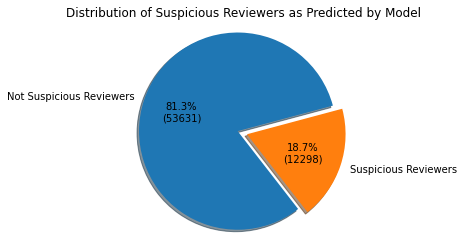

In [ ]:
import matplotlib.pyplot as plt

# # Creating plot 
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

non_suspicious_users = len(profiles_df) -  len(suspicious_users)

my_explode = (0, 0.1)
plt.pie([non_suspicious_users, len(suspicious_users)],labels=['Not Suspicious Reviewers','Suspicious Reviewers'],autopct=lambda pct: func(pct, [non_suspicious_users, len(suspicious_users)]),startangle=15, shadow = True, explode=my_explode)
plt.title("Distribution of Suspicious Reviewers as Predicted by Model")
plt.axis('equal')
plt.show()

In [ ]:
!pip install --upgrade rgmining-fraud-eagle

import fraud_eagle as feagle

# Create a graph with a parameter `epsilon`.
epsilon = 0.1
graph = feagle.ReviewGraph(epsilon)

reviewers = {}
for reviewer in set(filtered_df['acc_num']):
    reviewers[reviewer] = graph.new_reviewer(reviewer)

products = {}
for product in set(filtered_df['asin']):
    products[product] = graph.new_product(product)

for reviewer, product, rating in zip(filtered_df['acc_num'], filtered_df['asin'],filtered_df['cleaned_reviews_ratings']):
    graph.add_review(reviewers[reviewer], products[product], rating)

max_iteration = 10000
for i in range(max_iteration):

    # Run one iteration.
    diff = graph.update()
    print("Iteration {}...Difference={}".format(i + 1, diff))

    if diff < 10**-5: # Set 10^-5 as an acceptable small number.
        print("Difference is significantly small...Stopping Iteration...")
        break
top_users = [r.name for r in graph.reviewers if r.anomalous_score >= 0.8]
print(top_users)
print(len(top_users))

Requirement already up-to-date: rgmining-fraud-eagle in /usr/local/lib/python3.7/dist-packages (0.9.7)
Iteration 1...Difference=0.388888888888901
Iteration 2...Difference=0.395700671496719
Iteration 3...Difference=0.2769904700477022
Iteration 4...Difference=0.0002102618859668448
Iteration 5...Difference=6.905836746895488e-08
Difference is significantly small...Stopping Iteration...
['AHHSJAB2AVYBETCN6DON4VEIQMQQ', 'AEECLUKRRF47L4EJKMPBIL276R7Q', 'AE4M4BVD6UX4AM4AI5SX5HGEBHNA', 'AEF3UNWCZGHGWSA2BK7C2A532G4A', 'AFNWBUKYCSN5NDKVBW4S6X7SKJRQ', 'AGC3PB6AB46EV2WYUQLPZNMH2EAQ', 'AHJCRFW7TDJKPSGOY3UEQDXFW3KQ', 'AF34FJRDACORK6KIGSCPF6QWJ56A', 'AGKLBORB4ONPB7AUK7PWH3ETIE6A', 'AFGBFBDP4VCBUUDF5MEG5QQQUZKA', 'AESQ2UUQHHABZASAIH2VPVXQBJKA', 'AHWPMJSDVJV4XGIMTJC4D5X6BULQ', 'AGK4H2LDWVXEG2VFA2J4XHNQ5G4Q', 'AEDKRGKDIHQZST2I6TJQUR7MKMSQ', 'AHXPVSNOH5MEYHWSY3QHUSFGYSTQ', 'AGLAYHC7XJO7T4QVVXRAMJRHPZCQ', 'AG334CHQ74EYZEYBVU4TXWFTCB7A', 'AENIEYI6RGZBLWUHUMLRNI34IY6A', 'AF7S2YXVEAOJHKLVOFVTYMKHJ22A', 'AG7RY

In [ ]:
interested_df = df[df['acc_num'].isin(top_users)]
interested_columns = ['cleaned_reviews_date_posted','asin','acc_num','cleaned_reviews_verified','cleaned_reviews_ratings','cleaned_reviews_text']
current_df = interested_df[interested_columns]
current_df = current_df.sort_values(by=['asin','cleaned_reviews_date_posted'])
current_df.columns = ['Date Posted','Product ASIN','User','Verified Purchase','Rating','Text']
display(current_df)

,Date Posted,Product ASIN,User,Verified Purchase,Rating,Text
33322,1/17/2014,B0000531SW,AHKQY5QSH7FI666L6DQ5HWEQ2B4Q,1,0.4,order pale receive wa bit darker anticipate pr...
32649,10/14/2015,B0000531SW,AHR3UYFRA2UXKLBBNNWASR7NGNXA,1,0.2,even shade look picture
2897,12/23/2015,B0000531SW,AGI6IZIAPP4EOBAYAGTN3XY46TQA,1,0.4,usually love product wondering get knock somet...
35906,2/25/2015,B0000531SW,AGHFWGEC46Q6SPMUR3J57BCTZMLQ,1,0.4,product separate thick paste oil shake long ti...
36583,3/18/2015,B0000531SW,AF56IYU4HDWXFOLRSR773QCWR3OA,1,0.2,oily also look old would send back even worth ...
...,...,...,...,...,...,...
5448,8/31/2020,B0813N81WS,AHQJY2YV6AH5BVYRMNT2CREJRU7Q,1,0.2,bottle wasnt tight serum leak
2339,9/15/2019,B0813N81WS,AE4YMO7X7WY6M6IG5BZK5IX7HMKA,1,0.2,itsmeled help terribly overprice something wel...
4711,9/23/2020,B0813N81WS,AGLLOPVDULLW3X565T4N6ZQ2RWNA,0,0.4,use product couple month notice difference ski...
6111,9/4/2020,B0813N81WS,AGGIETFPEGFVUAD3ZRCHNLR4NXMQ,1,0.4,want like really irritated skinit must strong ...


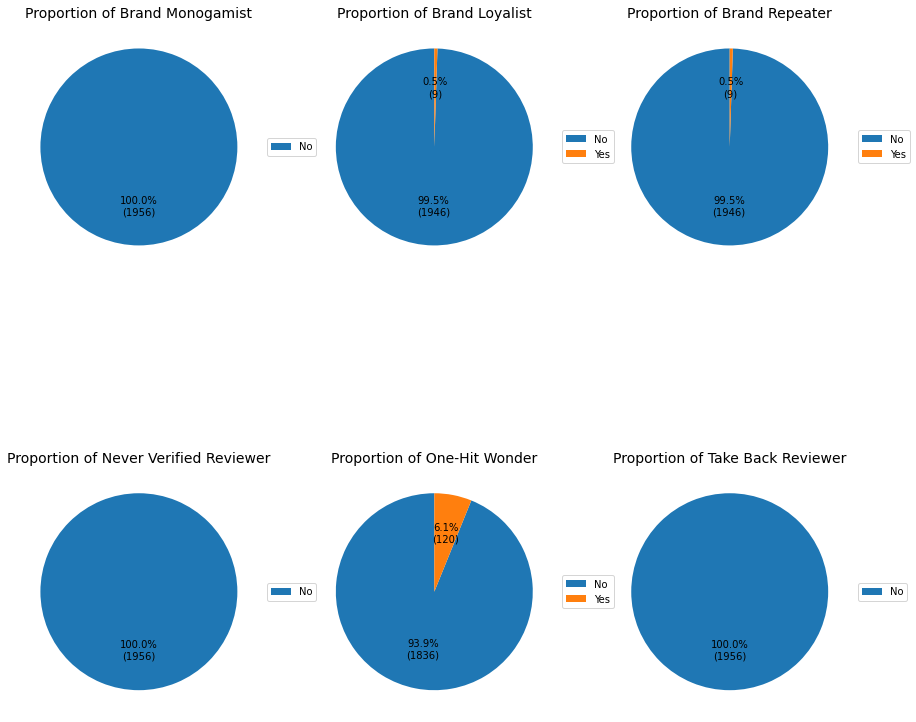

In [ ]:
import matplotlib.pyplot as plt
  
reviewers_df = profiles_df[profiles_df['acc_num'].isin(top_users)]

reviewers_plot_df = reviewers_df[['cleaned_brand_monogamist','cleaned_brand_loyalist','cleaned_brand_repeater','cleaned_never_verified_reviewer','cleaned_one_hit_wonder','cleaned_take_back_reviewer']]


sub_values = {'cleaned_brand_monogamist':'Brand Monogamist','cleaned_brand_loyalist':'Brand Loyalist','cleaned_brand_repeater':'Brand Repeater','cleaned_never_verified_reviewer':'Never Verified Reviewer','cleaned_one_hit_wonder':"One-Hit Wonder",'cleaned_take_back_reviewer':'Take Back Reviewer'}

fig, ax = plt.subplots(2,3, figsize=(15,15))

ax = ax.ravel()

for i, column in enumerate(reviewers_plot_df):
    temp_df = reviewers_plot_df.groupby(column).size().reset_index(name='count')
    column_values = list(temp_df['count'])
    if 0 not in list(temp_df[column]):
        column_values = [0, column_values[0]]
    elif 1 not in list(temp_df[column]):
        column_values = [column_values[0],0]
    index = ["No","Yes"]
    current_df = pd.DataFrame({index[0]: column_values[0], index[1]:column_values[1]}, index=[0])
    wedges, texts, autotexts = ax[i].pie(temp_df['count'], autopct=lambda pct: func(pct, temp_df['count']), shadow=False, startangle=90)

    ax[i].legend(wedges, index,
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))
    ax[i].set_ylabel('')
    ax[i].set_title("Proportion of {}".format(sub_values[column]),fontsize=14)


plt.show() 

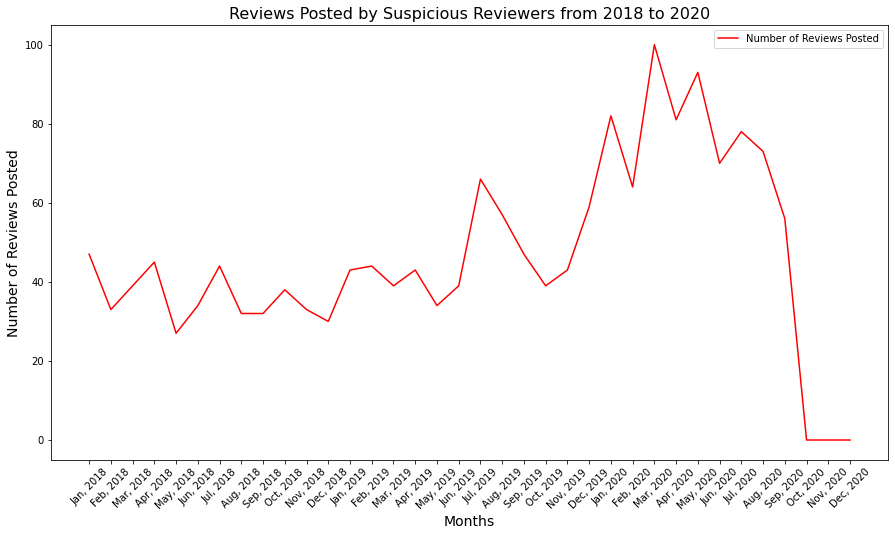

In [ ]:
df['cleaned_reviews_date_posted'] = pd.to_datetime(df['cleaned_reviews_date_posted'])
df['year'] = df['cleaned_reviews_date_posted'].dt.year
df['month'] = df['cleaned_reviews_date_posted'].dt.month
clusters_df = df[df['acc_num'].isin(top_users)]
final_clusters_df = pd.DataFrame()
fig= plt.subplots(figsize=(15,8))


color = {0:'g',1:'b',2:'r'}
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_dict = dict(zip(list(range(1,13)),months))
for i, year in enumerate([2018, 2019, 2020]):
    temp_clusters_df = clusters_df[clusters_df['year'] == year]

    count_clusters_df = pd.DataFrame()

    count_clusters_df['month'] = range(1,13)

    temp_count_clusters_df = temp_clusters_df.groupby(['month']).size().reset_index(name='count')

    count_clusters_df = count_clusters_df.merge(temp_count_clusters_df,how='left', left_on='month',right_on='month')

    count_clusters_df['year'] = year
    count_clusters_df = count_clusters_df.fillna(0)
    final_clusters_df = pd.concat([final_clusters_df,count_clusters_df])
    # plt.plot(months, count_df['count_clusters'],'-'+color[i],label="Number of Reviews Posted by Red Nodes in {}".format(year))
    # plt.plot(months, count_df['count_reviewers'], ':'+color[i],label="Number of Reviews Posted by Blue Nodes in {}".format(year))

final_clusters_df['month'] = final_clusters_df['month'].replace(months_dict)
month_year = []
for index, row in final_clusters_df.iterrows():
    month_year.append(row['month'] + ", " + str(row['year']))
final_clusters_df['month_year'] = month_year
plt.plot(month_year, final_clusters_df['count'],'-r',label="Number of Reviews Posted")
plt.title("Reviews Posted by Suspicious Reviewers from 2018 to 2020", fontsize=16)
plt.xlabel('Months', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Number of Reviews Posted', fontsize=14)
plt.legend()
plt.show()

In [ ]:
final_count_df = pd.DataFrame()


july_2019_df = clusters_df[(clusters_df['year'] == 2019) & (clusters_df['month'] == 7) ]
july_2020_df = clusters_df[(clusters_df['year'] == 2020) & (clusters_df['month'] == 7) ]

july_2019_count_products_df = july_2019_df.groupby('asin').size().reset_index(name='count')
july_2020_count_products_df = july_2020_df.groupby('asin').size().reset_index(name='count')

july_2019_count_profiles_df = july_2019_df.groupby('acc_num').size().reset_index(name='count')
july_2020_count_profiles_df = july_2020_df.groupby('acc_num').size().reset_index(name='count')

july_2019_df['custom_rating'] = [rating*5 for rating in list(july_2019_df['cleaned_reviews_ratings'])]
july_2020_df['custom_rating'] = [rating*5 for rating in list(july_2020_df['cleaned_reviews_ratings'])]

july_2019_ratings = sum(list(july_2019_df['custom_rating']))
july_2019_reviews = len(july_2019_df)
july_2019_average_rating = july_2019_ratings/july_2019_reviews
july_2020_ratings = sum(list(july_2020_df['custom_rating']))
july_2020_reviews = len(july_2020_df)
july_2020_average_rating = july_2020_ratings/july_2020_reviews


final_count_df['Month, Year'] = ["Jul, 2019", "Jul, 2020"]
final_count_df['Number of Reviews'] = [july_2019_reviews,july_2020_reviews]
final_count_df["Number of Products Reviewed"] = [len(july_2019_count_products_df),len(july_2020_count_products_df)]
final_count_df["Number of Users"] = [len(july_2019_count_profiles_df),len(july_2020_count_profiles_df)]
final_count_df['Minimum Stars Given'] = [min(list(july_2019_df['custom_rating'])),min(list(july_2020_df['custom_rating']))]
final_count_df['Maximum Stars Given'] = [max(list(july_2019_df['custom_rating'])),max(list(july_2020_df['custom_rating']))]
display(final_count_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,"Month, Year",Number of Reviews,Number of Products Reviewed,Number of Users,Minimum Stars Given,Maximum Stars Given
0,"Jul, 2019",66,31,54,1.0,2.0
1,"Jul, 2020",78,35,57,1.0,2.0


In [ ]:
july_2019_df = july_2019_df.merge(products_df[['asin','name']])
july_2020_df = july_2020_df.merge(products_df[['asin','name']])

july_2019_products = july_2019_df.groupby('name').size().reset_index(name='Jul, 2019')
july_2020_products = july_2020_df.groupby('name').size().reset_index(name='Jul, 2020')

# unique_names = list(set(list(july_2019_products['name']) + list(jan_2020_products['name']) + list(mar_2020_products['name']) + list(may_2020_products['name']) + list(july_2020_products['name'])))
unique_names = list(set(list(july_2019_products['name']) + list(july_2020_products['name'])))

final_count_df = pd.DataFrame()
final_count_df['name'] = unique_names

final_count_df = final_count_df.merge(july_2019_products, how='left',left_on='name', right_on='name')
final_count_df = final_count_df.merge(july_2020_products, how='left',left_on='name', right_on='name')
final_count_df.dropna(axis=0, how='all',inplace=True)
final_count_df = final_count_df.fillna(0)
for index,row in final_count_df.iterrows():
    if row['Jul, 2019'] > 0 and row['Jul, 2020'] > 0:
        continue
    else:
        final_count_df = final_count_df.drop(index)
final_count_df['name'] = final_count_df['name'].str.replace('-',' ')
final_count_df['diff'] = final_count_df['Jul, 2020'] - final_count_df['Jul, 2019']
final_count_df = final_count_df[final_count_df['diff'] > 0]
final_count_df = final_count_df.sort_values(by='diff',ascending=False)
final_count_df = final_count_df[:5]
final_count_df.columns = ['Name','Jul, 2019', 'Jul, 2020', 'Difference between periods']

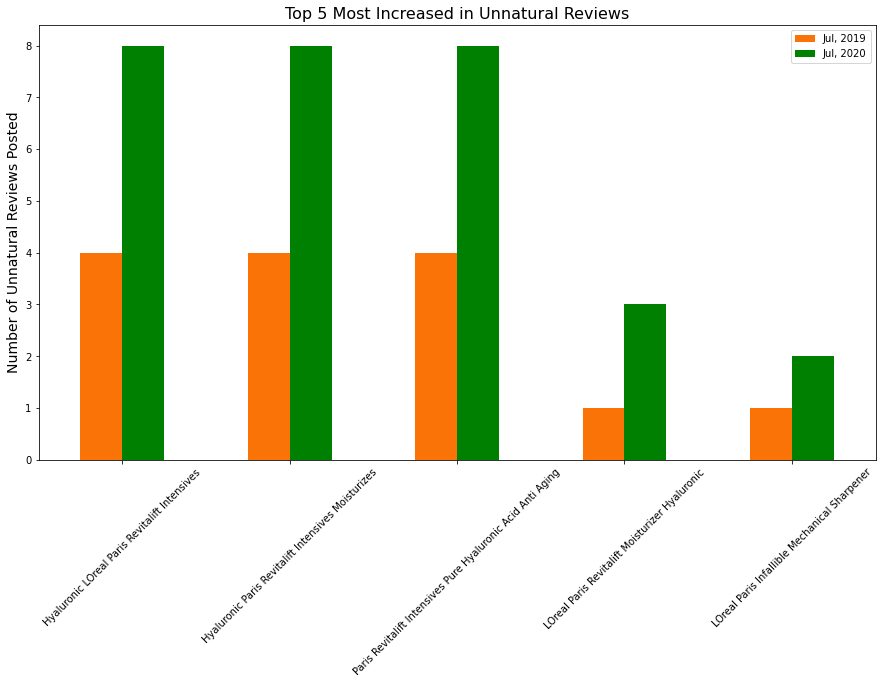

In [ ]:
fig, axes = plt.subplots(figsize=(15,8))

final_count_df[['Name','Jul, 2019', 'Jul, 2020']].plot(kind='bar',ax=axes,color=['#F97306','g'])
axes.set_ylabel('Number of Unnatural Reviews Posted', fontsize=14)
axes.set_title('Top 5 Most Increased in Unnatural Reviews',  fontsize=16)
axes.set_xticklabels(list(final_count_df['Name']),rotation = 45)
axes.legend()

plt.show()
# display(final_count_df)

In [ ]:
df = df.merge(products_df[['asin','name']])
total_products_year_products = df.groupby(['year']).size().reset_index(name='count')
products_year_products = df.groupby(['year','name']).size().reset_index(name='count')
total_products_year_products = total_products_year_products[total_products_year_products['year'].isin([2019,2020])]
products_year_products = products_year_products[products_year_products['year'].isin([2019,2020])]


new_products_year_products = pd.DataFrame({'name': list(set(final_count_df['Name']))})
for year in [2019,2020]:
    temp_df = products_year_products[products_year_products['year'] == year]
    temp_df['ranking'] = temp_df['count'].rank(ascending=False)
    temp_df['ranking'] = temp_df['ranking'].astype(int)
    temp_df['name'] = temp_df['name'].str.replace("-"," ")
    temp_df = temp_df[temp_df['name'].isin(list(set(final_count_df['Name'])))]
    temp_df = temp_df[['name','count','ranking']]
    temp_df.columns = ['name','Total Reviews ({})'.format(year), 'Ranking ({})'.format(year)]
    new_products_year_products = new_products_year_products.merge(temp_df)

new_products_year_products = new_products_year_products.rename(columns={'name':'Name'})
new_products_year_products['Name'] = new_products_year_products['Name'].str.replace("-"," ")
new_products_year_products = new_products_year_products.sort_values(by=['Ranking (2019)', 'Ranking (2020)'],ascending=True)
display(new_products_year_products)
display(new_products_year_products[['Name']+[column for column in new_products_year_products.columns if 'Ranking' in column]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Name,Total Reviews (2019),Ranking (2019),Total Reviews (2020),Ranking (2020)
1,Hyaluronic LOreal Paris Revitalift Intensives,427,8,509,6
2,Paris Revitalift Intensives Pure Hyaluronic Ac...,427,8,509,6
4,Hyaluronic Paris Revitalift Intensives Moistur...,427,8,509,6
0,LOreal Paris Infallible Mechanical Sharpener,319,14,208,18
3,LOreal Paris Revitalift Moisturizer Hyaluronic,200,26,221,14


,Name,Ranking (2019),Ranking (2020)
1,Hyaluronic LOreal Paris Revitalift Intensives,8,6
2,Paris Revitalift Intensives Pure Hyaluronic Ac...,8,6
4,Hyaluronic Paris Revitalift Intensives Moistur...,8,6
0,LOreal Paris Infallible Mechanical Sharpener,14,18
3,LOreal Paris Revitalift Moisturizer Hyaluronic,26,14


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


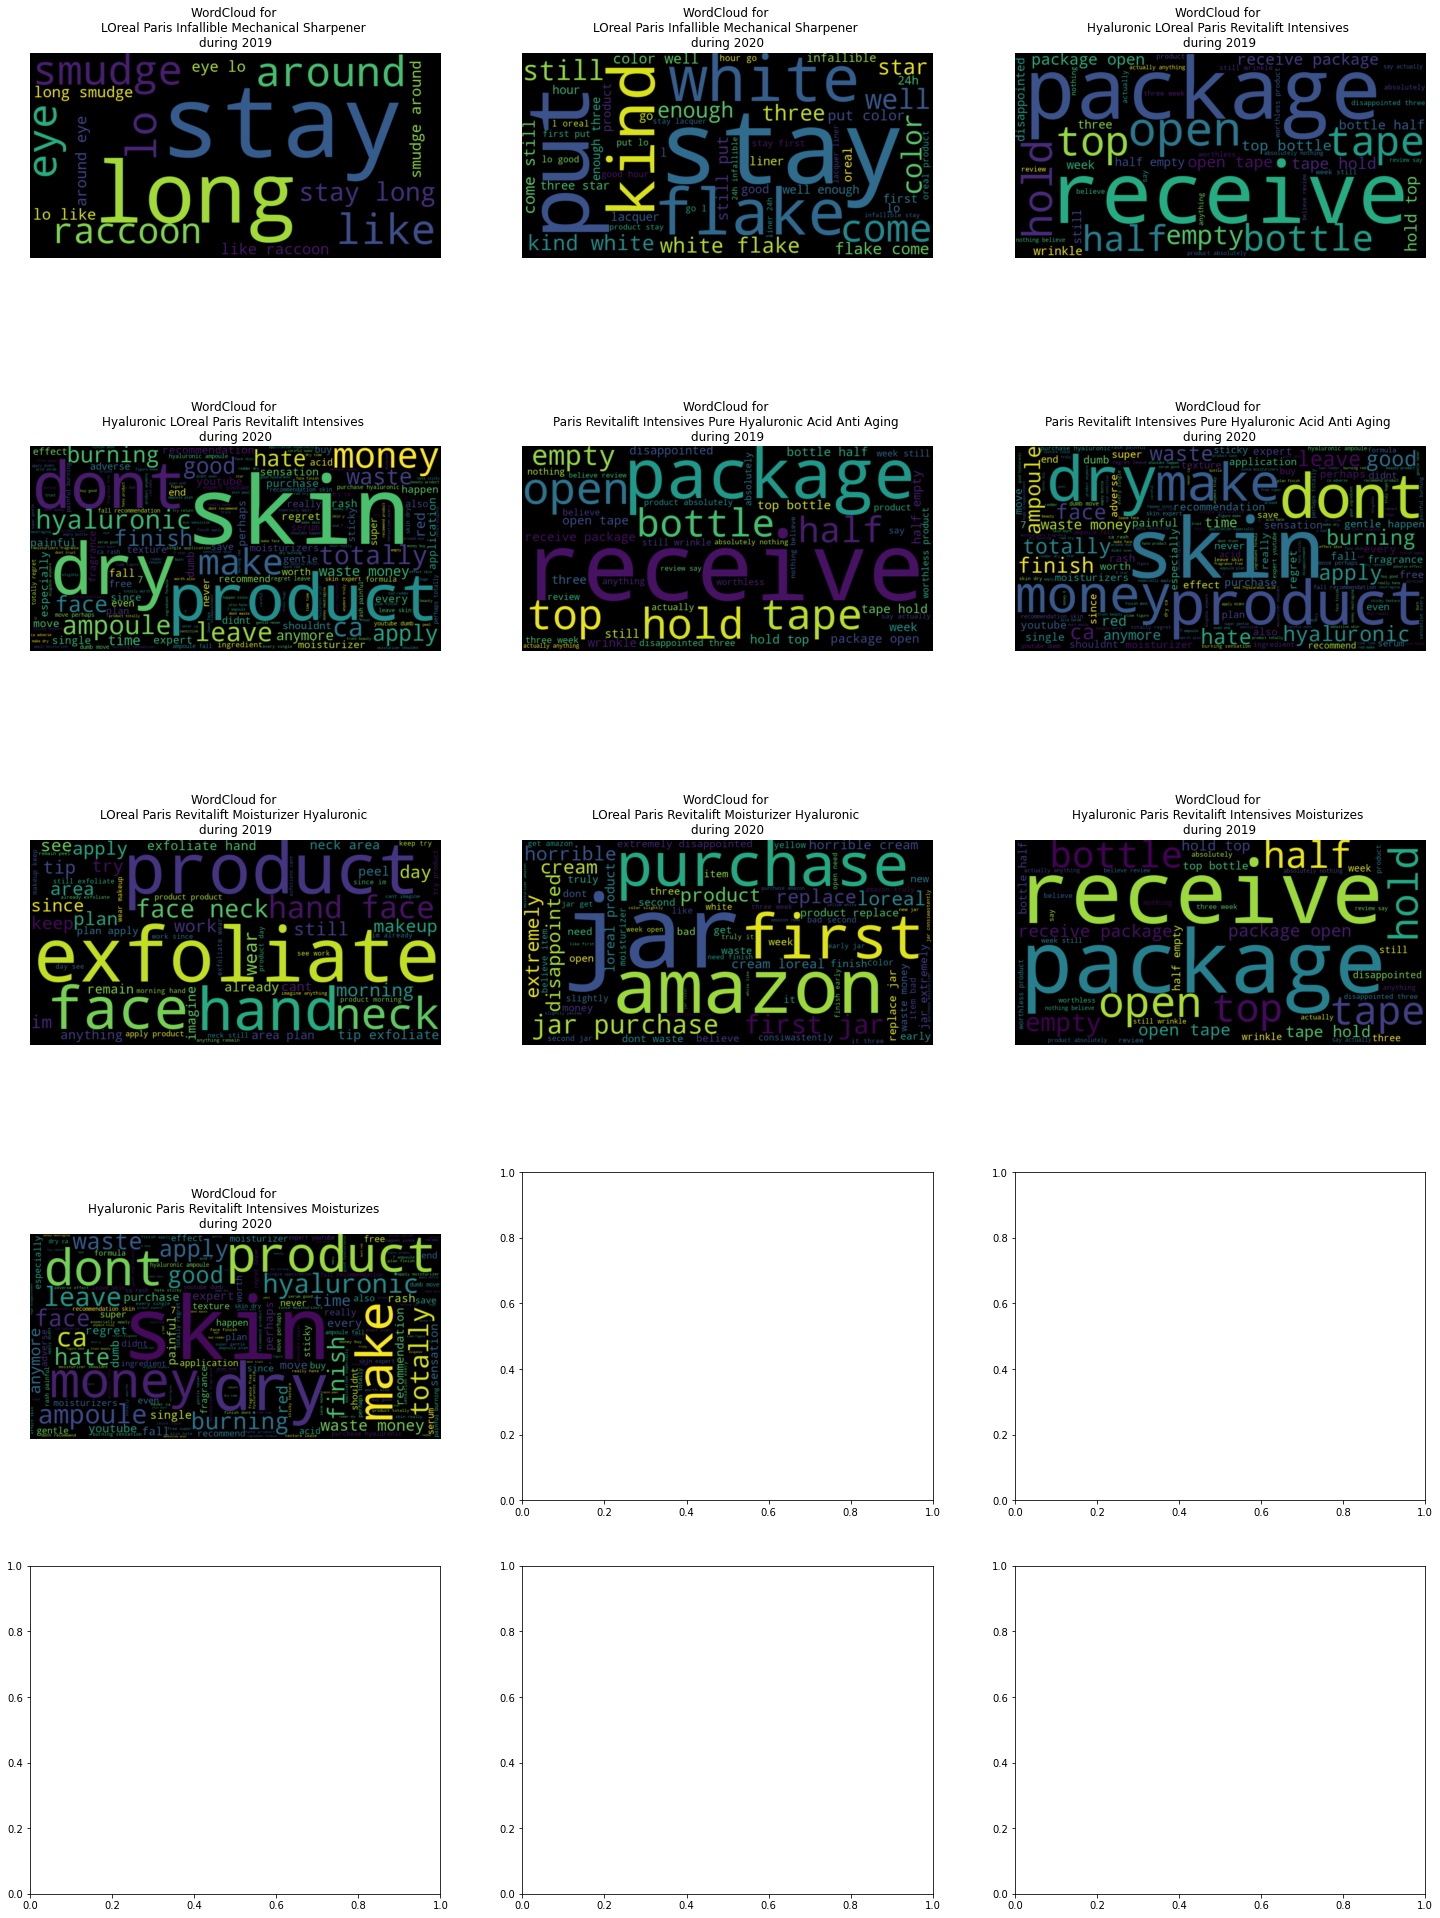

In [ ]:
review_text_df = pd.concat([july_2019_df[['name','year','cleaned_reviews_text']],july_2020_df[['name','year','cleaned_reviews_text']]])
review_text_df['name'] = review_text_df['name'].str.replace("-"," ")

!pip install nltk==3.4
import nltk
nltk.download('punkt')
from nltk.util import ngrams
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(text):
    # text = [nltk.word_tokenize(sentence) for sentence in text]

    words = []
    for sentence in text:
        for word in ['wa','use','doe','ok','oh','gosh']:
            sentence = sentence.replace(word, "")
        sentence = sentence.replace('ste',"waste")
        sentence = nltk.word_tokenize(sentence)
        for i in range(1,3):
            grams = ngrams(sentence, i)

            for gram in grams:
                words.append(' '.join(gram))
                
    counter = Counter()
    counter.update(words)
    
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(dict(counter))
    return wordcloud

# unique_names = list(set(review_text_df['name']))

fig, axs = plt.subplots(len(list(set(final_count_df['Name']))), 3, figsize=(25,35))

axs = axs.ravel()

count = 0

for name in list(set(final_count_df['Name'])):
    for year in [2019,2020]:
        temp_df = review_text_df[(review_text_df['name'] == name) & (review_text_df['year'] == year)]
        text = list(temp_df['cleaned_reviews_text'])
        if len(text) > 0:
            current_wordcloud = generate_wordcloud(text)
            axs[count].imshow(current_wordcloud, interpolation='bilinear')
            axs[count].set_title('WordCloud for \n{} \nduring {}'.format(name,year))
        axs[count].axis("off")
        
        count += 1

plt.show()